In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')
%matplotlib inline

In this project, we are going to predict the units sold per item of a supermarket. We are given three csv data sets<br>
- master_file is the main file and it is weekly aggregated
- cross_effects_table contains the information of the items bought along 
- dim_table this is a map between item_no and categories<br>

Since not all items are sold every week, the performance of our model will be measured by computing the RMSE in each category

# Data Exploration

### Reading data and checking for missing values

In [2]:
#Reading the master file
df1 = pd.read_csv('master_file.csv')
df1.head()

,ITEM_NO,GROUP_ID,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,NET_PRICE,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK
0,6156216,TR6156216,201936,TR,FRONT,1,9.916667,NaN,-2.120264,0.013158,0.12,2.294217,36
1,6156216,TR6156216,202004,TR,FRONT,1,9.891305,NaN,-0.776529,0.013158,0.46,2.291656,4
2,2669722,IG2669722,201847,IG,FRONT,0,3.934955,NaN,6.104793,0.674576,448.00,1.369900,47
3,2669722,IG2669722,201848,IG,FRONT,0,3.975193,Good Friday,5.963579,0.633898,389.00,1.380073,48
4,2669722,IG2669722,201849,IG,FRONT,0,3.490547,NaN,6.817831,0.823729,914.00,1.250058,49


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113886 entries, 0 to 113885
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ITEM_NO            113886 non-null  int64  
 1   GROUP_ID           113886 non-null  object 
 2   YEAR_WK            113886 non-null  int64  
 3   BANNER_NAME        113886 non-null  object 
 4   POSITION_ON_FLYER  113886 non-null  object 
 5   KG_FLAG            113886 non-null  int64  
 6   NET_PRICE          113886 non-null  float64
 7   HOLIDAY            31616 non-null   object 
 8   LOG_UNITS          113886 non-null  float64
 9   DISTRIBUTION       113886 non-null  float64
 10  UNITS_WEIGHT_SOLD  113886 non-null  float64
 11  LOG_NET_PRICE      113886 non-null  float64
 12  WEEK               113886 non-null  int64  
dtypes: float64(5), int64(4), object(4)
memory usage: 11.3+ MB


*There are **113886** records. The feature **HOLIDAY** has a lot of missing values which is okay. Not every week is a holiday :)*

In [4]:
#let's select a item_no
df1.query("ITEM_NO==4907644 and YEAR_WK==201846")

,ITEM_NO,GROUP_ID,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,NET_PRICE,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK
21493,4907644,CO4907644,201846,CO,FRONT,0,1.316667,NaN,3.295837,0.036058,27.0,0.275103,46
21596,4907644,OT4907644,201846,OT,FRONT,0,1.240169,NaN,5.686975,0.159292,295.0,0.215248,46
21694,4907644,BO4907644,201846,BO,FRONT,0,1.289763,NaN,5.129899,0.637681,169.0,0.254459,46
21797,4907644,IG4907644,201846,IG,FRONT,0,1.175207,NaN,8.133587,0.959322,3407.0,0.161444,46
21894,4907644,TR4907644,201846,TR,FRONT,0,0.989929,NaN,6.889591,0.828947,982.0,-0.010122,46


*Item sold the same YEAR_WK might be associated with different banner name and different prices  with respect to the distribution (place)*

In [5]:
df2 = pd.read_csv('cross_effects_table_TRUNCATED.csv')
df2.head()

,GROUP_ID,YEAR_WK,CROSS_EFFECT_TYPE,CROSS_EFFECT_LOG_PRICE,BANNER_NAME,ITEM_NO
0,TR4907644,201846.0,HALO_ITEM_LOG_PRICE_01,1.075020,TR,4907644.0
1,TR4907644,201846.0,HALO_ITEM_LOG_PRICE_02,0.916291,TR,4907644.0
2,TR4907644,201846.0,HALO_ITEM_LOG_PRICE_03,0.000000,TR,4907644.0
3,TR4907644,201846.0,HALO_ITEM_LOG_PRICE_04,1.341123,TR,4907644.0
4,TR4907644,201846.0,HALO_ITEM_LOG_PRICE_05,0.733477,TR,4907644.0


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163832 entries, 0 to 163831
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   GROUP_ID                98380 non-null  object 
 1   YEAR_WK                 98380 non-null  float64
 2   CROSS_EFFECT_TYPE       98380 non-null  object 
 3   CROSS_EFFECT_LOG_PRICE  98380 non-null  float64
 4   BANNER_NAME             98380 non-null  object 
 5   ITEM_NO                 98380 non-null  float64
dtypes: float64(3), object(3)
memory usage: 7.5+ MB


*df2 has **163832** entries but only 98380 non null rows. That means the remaining rows are null so we drop them*

In [7]:
#dropping null rows
df2.dropna(axis=0, how='all', inplace=True)

In [8]:
#reading the file
df3 = pd.read_csv('dim_table.csv')
df3.head()

,ITEM_NO,LVL4_NAME
0,5840385,Hot Beverages
1,2450712,Waste Bags
2,6532706,Pasta Sauce and Toppings
3,3111313,Fresh Chicken / Fowl
4,6460516,Waste Bags


In [9]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ITEM_NO    484 non-null    int64 
 1   LVL4_NAME  484 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.7+ KB


*There are no missing values in df3*

### More exploration

In [10]:
#join data sets
data1 = pd.merge(df1, df3, how='left', on='ITEM_NO')
data2 = pd.merge(df2, df3, how="left", on="ITEM_NO")
data1.head(2)

,ITEM_NO,GROUP_ID,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,NET_PRICE,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME
0,6156216,TR6156216,201936,TR,FRONT,1,9.916667,NaN,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds
1,6156216,TR6156216,202004,TR,FRONT,1,9.891305,NaN,-0.776529,0.013158,0.46,2.291656,4,Frsh Bf Grnds


In [11]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113886 entries, 0 to 113885
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ITEM_NO            113886 non-null  int64  
 1   GROUP_ID           113886 non-null  object 
 2   YEAR_WK            113886 non-null  int64  
 3   BANNER_NAME        113886 non-null  object 
 4   POSITION_ON_FLYER  113886 non-null  object 
 5   KG_FLAG            113886 non-null  int64  
 6   NET_PRICE          113886 non-null  float64
 7   HOLIDAY            31616 non-null   object 
 8   LOG_UNITS          113886 non-null  float64
 9   DISTRIBUTION       113886 non-null  float64
 10  UNITS_WEIGHT_SOLD  113886 non-null  float64
 11  LOG_NET_PRICE      113886 non-null  float64
 12  WEEK               113886 non-null  int64  
 13  LVL4_NAME          109443 non-null  object 
dtypes: float64(5), int64(4), object(5)
memory usage: 13.0+ MB


**LVL4_NAME** *has 109443 nonnull values however the total number of records is 113886. So  **LVL4_NAME** has 4443 missing values. Let's check*

In [12]:
data1[data1['LVL4_NAME'].notna()==False].head(2)

,ITEM_NO,GROUP_ID,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,NET_PRICE,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME
2680,5942105,IG5942105,202043,IG,FRONT,0,6.49,NaN,1.386294,0.010169,4.0,1.870262,43,NaN
2681,5942105,IG5942105,202044,IG,FRONT,0,6.49,NaN,2.995732,0.064407,20.0,1.870262,44,NaN


*some ITEM_NO are uncategorized. Let's check again!*<br>
*Below, we see that ITEM_NO=5942105 is not listed in df3*

In [13]:
df3.query("ITEM_NO==5942105")

,ITEM_NO,LVL4_NAME


_Let's rename NaN in LVL4_NAME to Uncategorized (ITEM_NO without category)_

In [14]:
data1.LVL4_NAME.fillna('Uncategorized', axis=0, inplace=True)
data1.query("ITEM_NO==5942105").head(2)

,ITEM_NO,GROUP_ID,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,NET_PRICE,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME
2680,5942105,IG5942105,202043,IG,FRONT,0,6.49,NaN,1.386294,0.010169,4.0,1.870262,43,Uncategorized
2681,5942105,IG5942105,202044,IG,FRONT,0,6.49,NaN,2.995732,0.064407,20.0,1.870262,44,Uncategorized


_We also replace NaN in HOLIDAY with 'Normal'_

In [15]:
data1.HOLIDAY.fillna('Normal', axis=0, inplace=True)
data1.head(2)

,ITEM_NO,GROUP_ID,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,NET_PRICE,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME
0,6156216,TR6156216,201936,TR,FRONT,1,9.916667,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds
1,6156216,TR6156216,202004,TR,FRONT,1,9.891305,Normal,-0.776529,0.013158,0.46,2.291656,4,Frsh Bf Grnds


In [16]:
data2.head(3)

,GROUP_ID,YEAR_WK,CROSS_EFFECT_TYPE,CROSS_EFFECT_LOG_PRICE,BANNER_NAME,ITEM_NO,LVL4_NAME
0,TR4907644,201846.0,HALO_ITEM_LOG_PRICE_01,1.075020,TR,4907644.0,Canned Vegetables
1,TR4907644,201846.0,HALO_ITEM_LOG_PRICE_02,0.916291,TR,4907644.0,Canned Vegetables
2,TR4907644,201846.0,HALO_ITEM_LOG_PRICE_03,0.000000,TR,4907644.0,Canned Vegetables


In [17]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98380 entries, 0 to 98379
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   GROUP_ID                98380 non-null  object 
 1   YEAR_WK                 98380 non-null  float64
 2   CROSS_EFFECT_TYPE       98380 non-null  object 
 3   CROSS_EFFECT_LOG_PRICE  98380 non-null  float64
 4   BANNER_NAME             98380 non-null  object 
 5   ITEM_NO                 98380 non-null  float64
 6   LVL4_NAME               97980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 6.0+ MB


*LVL4_NAME has missing values but it is okay since we these have been taking care in the data set data1*

In [18]:
#Statistical description
data1.describe()

,ITEM_NO,YEAR_WK,KG_FLAG,NET_PRICE,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK
count,1.138860e+05,113886.000000,113886.000000,113886.000000,113886.000000,113886.000000,113886.000000,113886.000000,113886.000000
mean,3.876331e+06,201964.128163,0.085700,5.611682,4.403754,0.350197,1091.811437,1.497507,26.621358
std,2.059034e+06,57.215140,0.279921,4.217377,2.211726,0.333606,7322.975675,0.679366,15.037543
min,2.101720e+05,201846.000000,0.000000,0.010000,-3.506558,0.002404,0.030000,-4.605170,1.000000
25%,2.339732e+06,201920.000000,0.000000,3.203333,2.890372,0.053097,18.000000,1.164192,14.000000
50%,3.814063e+06,201946.000000,0.000000,4.490000,4.143135,0.217391,63.000000,1.501853,27.000000
75%,5.354015e+06,202020.000000,0.000000,6.555030,5.843544,0.641540,345.000000,1.880233,40.000000
max,9.903009e+06,202046.000000,1.000000,51.757810,13.335174,1.000000,618575.000000,3.946575,52.000000


*Investigate data distribution*

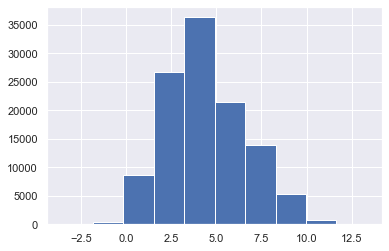

In [19]:
data1.LOG_UNITS.hist()
#LOG_UNITS follows Gaussian distribution with mean and std given above

*LOG_UNITS has a nice Gaussian distribution which favors regression methods*

*What is the average log unit, min, max in each category?<br>
It looks like we have peaks in most of these category since the deviation from the mean is high. A boxplot will give a better insight. This will be displayed further down*

In [20]:
data1.groupby(by="LVL4_NAME").agg(mean=("LOG_UNITS",'mean'),min=("LOG_UNITS",'min'), max=("LOG_UNITS",'max'), std=("LOG_UNITS",'std'))

,mean,min,max,std
LVL4_NAME,,,,
Baking Flour,3.913457,0.000000,10.011310,2.086931
Bathroom Tissue,4.216222,0.000000,10.607797,1.846060
Books,1.809238,0.000000,7.323831,1.823920
Canned Vegetables,4.477267,0.000000,10.365617,2.279956
Cleaners,3.547745,0.000000,8.708309,1.787956
Cookies,4.787071,-1.448170,10.633232,1.931398
Craft Beer,3.814311,0.000000,7.949797,1.691680
Dairy Cheese,4.832328,0.000000,11.942439,2.086832
Dry Pasta,4.682573,-2.407946,9.898927,2.086840


*What is the average price, min, max in each category?<br>
The price deviation from the mean in each category is relatively small*

In [21]:
data1.groupby(by="LVL4_NAME").agg(mean=("LOG_NET_PRICE",'mean'),min=("LOG_NET_PRICE",'min'), max=("LOG_NET_PRICE",'max'), std=("LOG_NET_PRICE",'std'))

,mean,min,max,std
LVL4_NAME,,,,
Baking Flour,1.714542,-0.010050,3.135059,0.607995
Bathroom Tissue,1.785267,-0.010050,2.889816,0.505545
Books,2.268614,0.048790,3.425890,0.837201
Canned Vegetables,0.361027,-0.923005,2.196113,0.431483
Cleaners,1.413651,0.000000,2.943913,0.262026
Cookies,1.298934,0.512495,2.995232,0.219332
Craft Beer,1.931224,0.688135,2.900322,0.418184
Dairy Cheese,1.670385,-0.235722,2.995232,0.298723
Dry Pasta,0.877488,-0.127833,1.467874,0.307984


*What category is the most sold?*

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text xticklabel objects>)

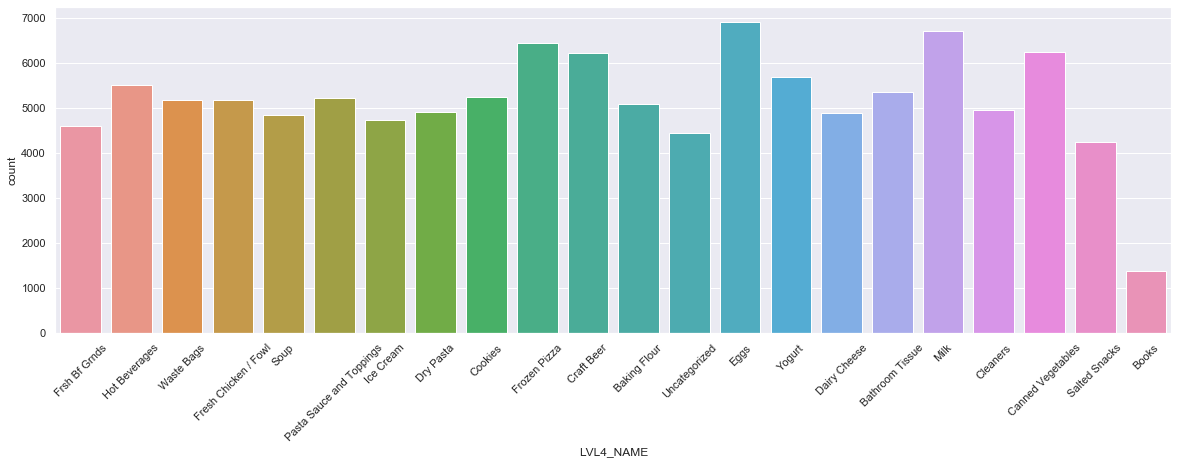

In [22]:
f, ax = plt.subplots(figsize=(20,6))
sns.countplot(x='LVL4_NAME', data=data1, ax=ax)
plt.xticks(rotation=45)

*The most sold category is Eggs followed by Milk*

In [23]:
#let's display the information of the above graph numerically
summary_table = data1.groupby(by=["LVL4_NAME"]).agg(FREQ=("ITEM_NO","count"),TOTAL_UNITS=("LOG_UNITS","sum"))
summary_table.sort_values('FREQ', ascending=False).head(3)

,FREQ,TOTAL_UNITS
LVL4_NAME,,
Eggs,6900,35240.218763
Milk,6713,34713.051793
Frozen Pizza,6439,25846.669684


*What category has the most unit sold?*

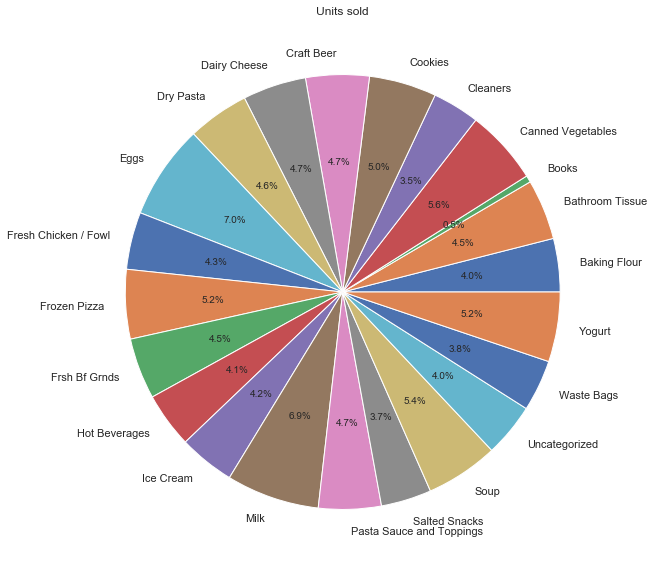

In [24]:
summary_table.plot.pie(y='TOTAL_UNITS', legend=False, autopct='%1.1f%%', label='', title='Units sold', figsize=(20, 10))

_The category with most unit bought is Eggs, followed by Milk. This makes sense since the more the item is bought so its unit increases.<br>
In fact there is a natural positive correlation between frequency and unit sold_

*What Banner has the most sale?*<br>
*IG is the banner with the most sale*

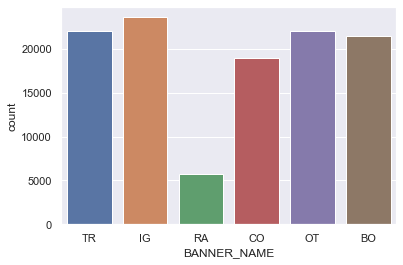

In [25]:
sns.countplot(x='BANNER_NAME', data=data1)

*What is the banner distribution with respect to the category?*

*In every category, IG is the banner with the most sale except for Baking Flour (OT) and Bathroom Tissue (OT).<br> We see that some category have lesser sale with some banner, e.g. Eggs have less sale when is it associated with the banner RA. Banner is important feature thereof*

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text xticklabel objects>)

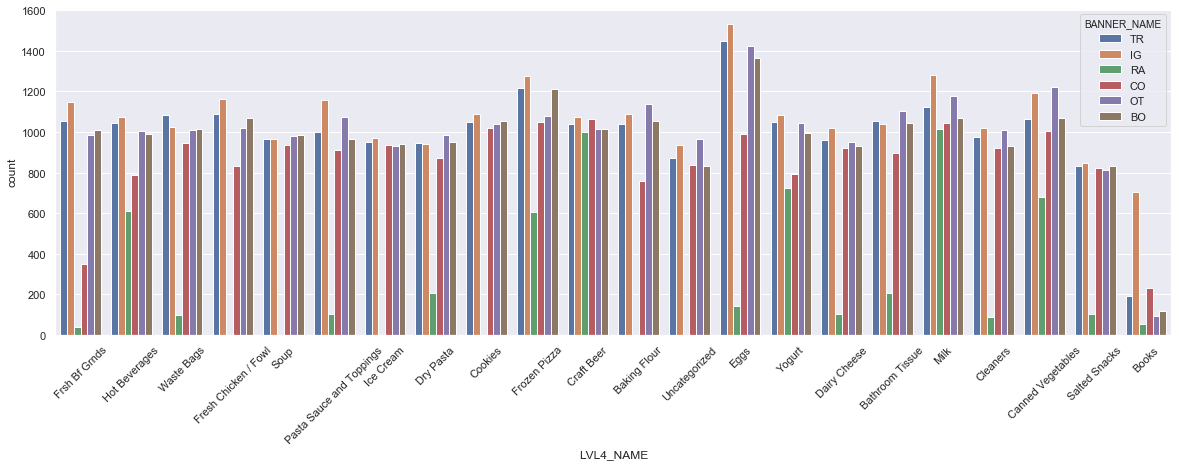

In [26]:
f, ax = plt.subplots(figsize=(20,6))
sns.countplot(x='LVL4_NAME', data=data1, hue='BANNER_NAME', ax=ax)
plt.xticks(rotation=45)

*What is the position of the flyer has the most sale?<br>
The position on the flyer is FRONT. No_Ad is so negligeable that POSITION_ON_FLYER might not be an important feature*

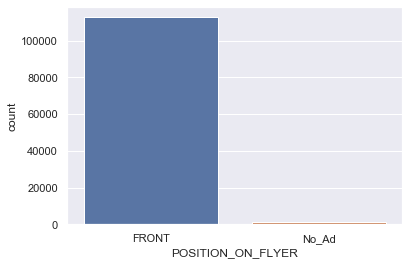

In [27]:
sns.countplot(x='POSITION_ON_FLYER', data=data1)

_What is the category the most positioning in front on the flyer?<br>
Again Eggs, Milk are the most found in the front of the flyer_

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text xticklabel objects>)

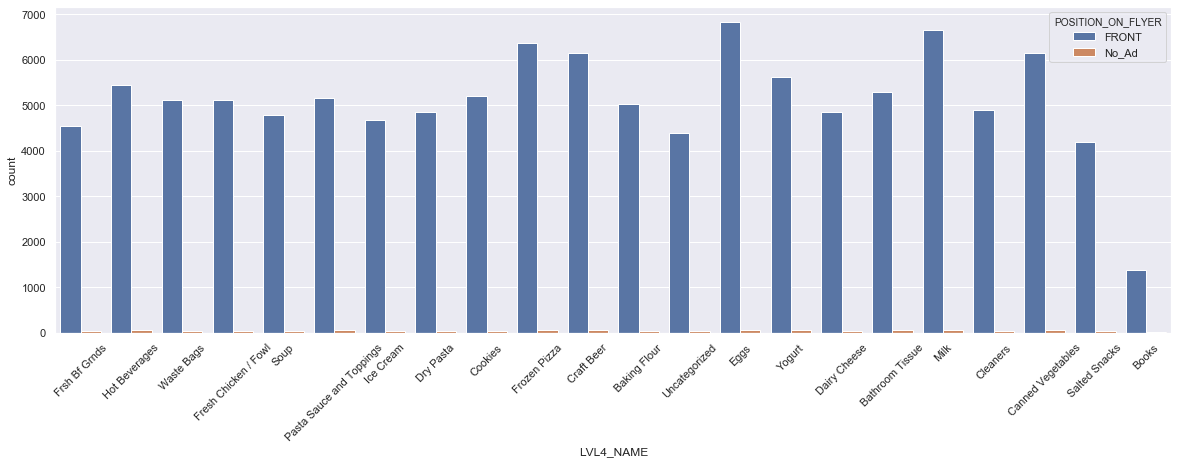

In [28]:
f, ax = plt.subplots(figsize=(20,6))
sns.countplot(x='LVL4_NAME', data=data1, hue='POSITION_ON_FLYER', ax=ax)
plt.xticks(rotation=45)

*What is the influance of KG_FLAG?<br>
First we can see from the statistical description of data1 that the 75th percentile value is below 0*

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text xticklabel objects>)

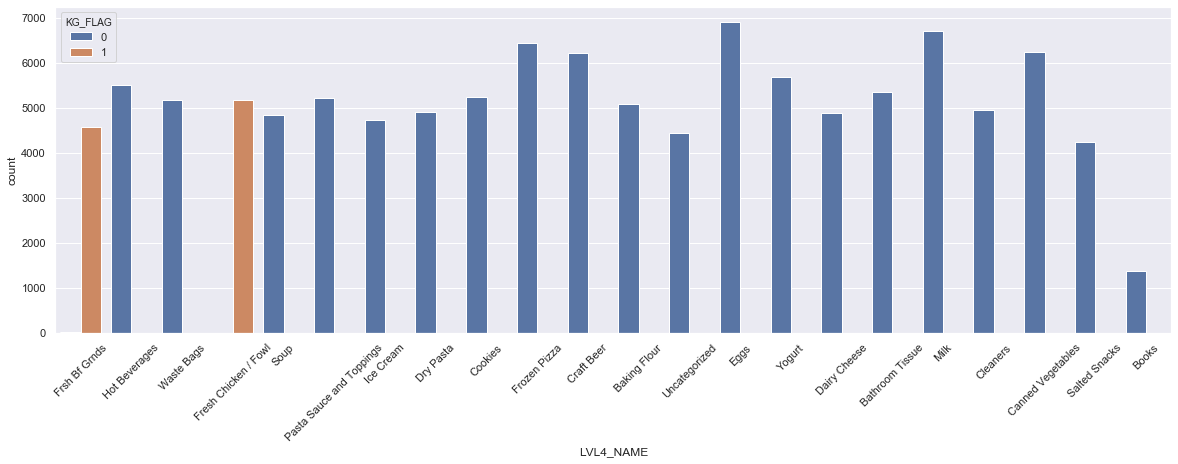

In [29]:
f, ax = plt.subplots(figsize=(20,6))
sns.countplot(x='LVL4_NAME', data=data1, hue='KG_FLAG', ax=ax)
plt.xticks(rotation=45)

_Since we don't have a clear idea on how KG_FLAG influence the sale, let's plot a heatmap to see how variables are correlated to each others_

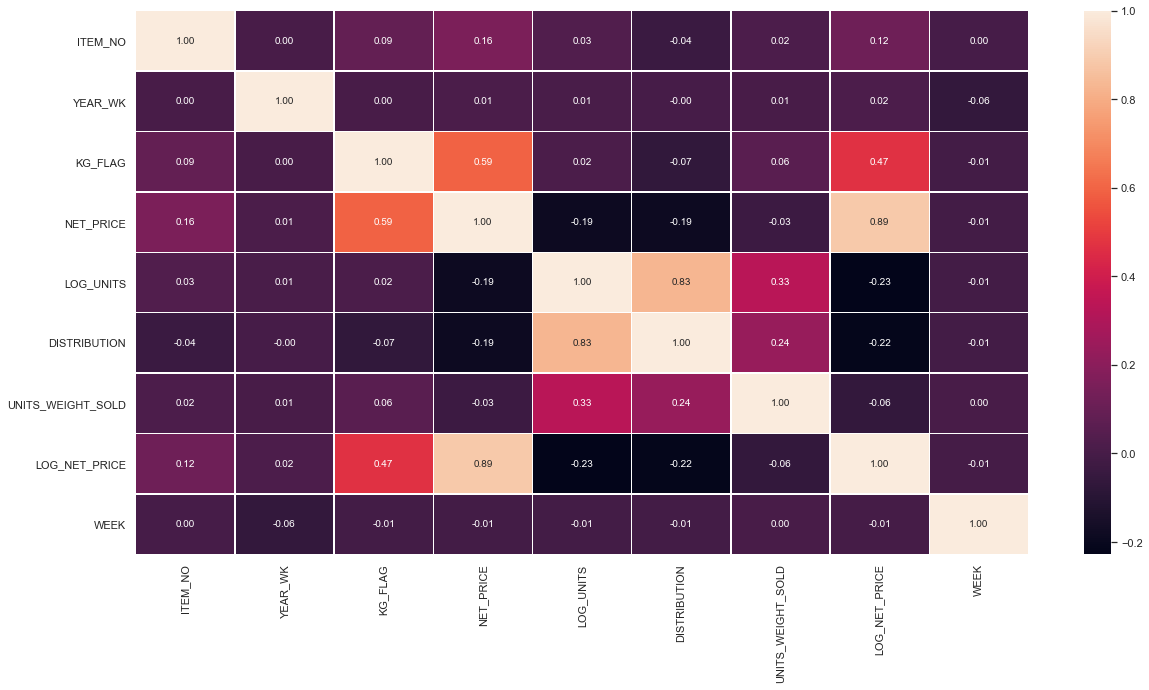

In [30]:
cor_mat = df1.corr()
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(cor_mat, annot=True, fmt=".2f", linewidths=.5, ax=ax)

*It seems that KG_FLAG somehow influance the price of the ITEM. Maybe KG_FLAG indicates whether the price is a promotion or not!<br>
Observe that **DISTRIBUTION** is strongly (positive) correlated with LOG_UNITS. Maybe some distribution (place) are located in dense population area or maybe there are more promotion occuring!*

*What is the holiday with the most sale per category?*

In [31]:
#Extract holidays data
holidays = data1[data1.HOLIDAY != 'Normal']
holidays.head(2)

,ITEM_NO,GROUP_ID,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,NET_PRICE,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME
3,2669722,IG2669722,201848,IG,FRONT,0,3.975193,Good Friday,5.963579,0.633898,389.0,1.380073,48,Hot Beverages
6,2669722,IG2669722,201851,IG,FRONT,0,3.729424,Easter_Monday,6.492240,0.732203,660.0,1.316254,51,Hot Beverages


In [32]:
#summarize
grp_hol = holidays.groupby(by=['LVL4_NAME', 'HOLIDAY']).agg(FREQ=("ITEM_NO","count"), TOTAL_UNITS=("LOG_UNITS", "sum")).reset_index()
grp_hol.head(5)

,LVL4_NAME,HOLIDAY,FREQ,TOTAL_UNITS
0,Baking Flour,Academy_Awards,47,199.811690
1,Baking Flour,Canada Day,92,362.013113
2,Baking Flour,Chinese_New_Year,46,195.288374
3,Baking Flour,Christmas / Boxing,117,565.263922
4,Baking Flour,Civic Holiday (Not for all),93,377.255575


_Given that we have almost the same number of categories in both HOLIDAY and LVL4_NAME, it is difficult to visualize the distribution. So we display the max count in each category_

In [33]:
#create a function that display the nth most sold category on a holiday
#By default we extract the most, n=1
def Extract_most_sold(grp_hol, n=1):
    uniq_cat = grp_hol.LVL4_NAME.unique()
    cols = grp_hol.columns.tolist()
    hol_summ = pd.DataFrame(columns=cols)
    for cat in uniq_cat:
        x = "LVL4_NAME=="  + '"' + str(cat) + '"' 
        hol_summ = hol_summ.append(grp_hol.query(x).sort_values('FREQ', ascending=False).iloc[: n])
    return hol_summ
#print
hol_summary = Extract_most_sold(grp_hol, n=1)
hol_summary.head()

,LVL4_NAME,HOLIDAY,FREQ,TOTAL_UNITS
3,Baking Flour,Christmas / Boxing,117,565.263922
22,Bathroom Tissue,Christmas / Boxing,129,579.909976
39,Books,Canada Day,23,47.952414
61,Canned Vegetables,Christmas / Boxing,143,743.862529
81,Cleaners,Christmas / Boxing,110,417.179192


*Christmas/Boxing is the holiday with the most sale  for all categories except Books which is associated with Canada Day*

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text xticklabel objects>)

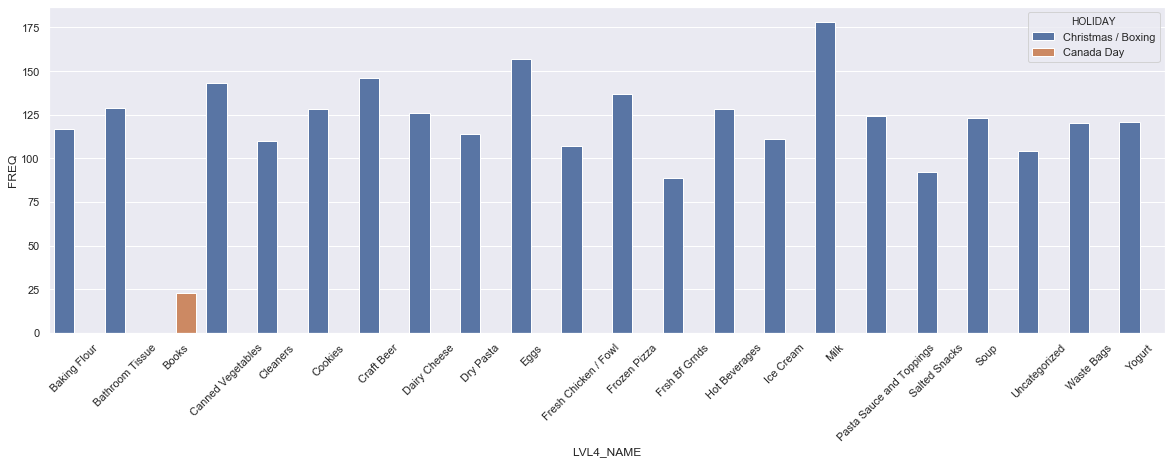

In [34]:
f, ax = plt.subplots(figsize=(20,6))
sns.barplot(x='LVL4_NAME', y='FREQ', data=hol_summary, hue='HOLIDAY', ax=ax)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text xticklabel objects>)

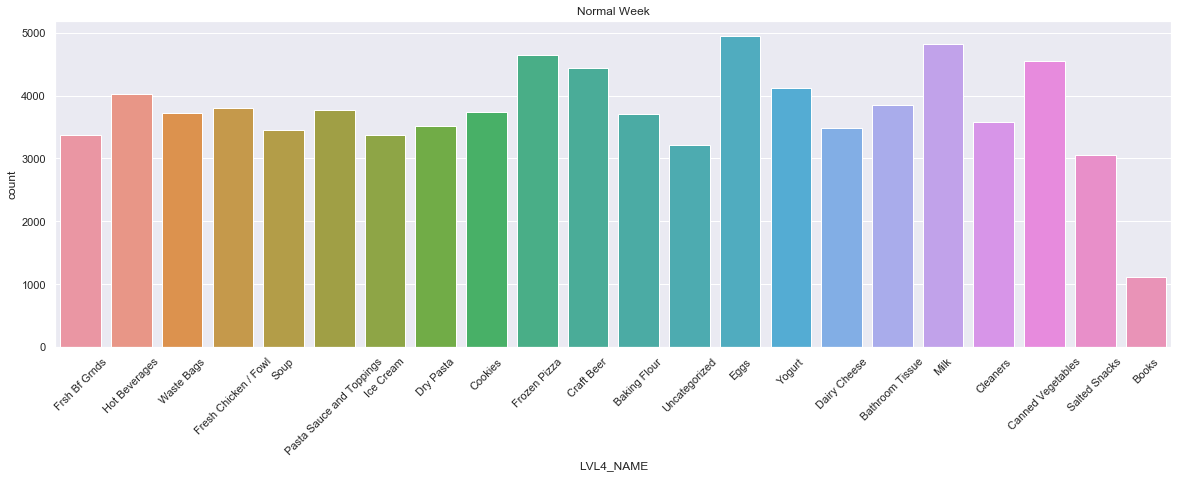

In [35]:
f, ax = plt.subplots(figsize=(20,6))
sns.countplot(x='LVL4_NAME', data=data1.query("HOLIDAY=='Normal'"), ax=ax)
plt.title("Normal Week")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text xticklabel objects>)

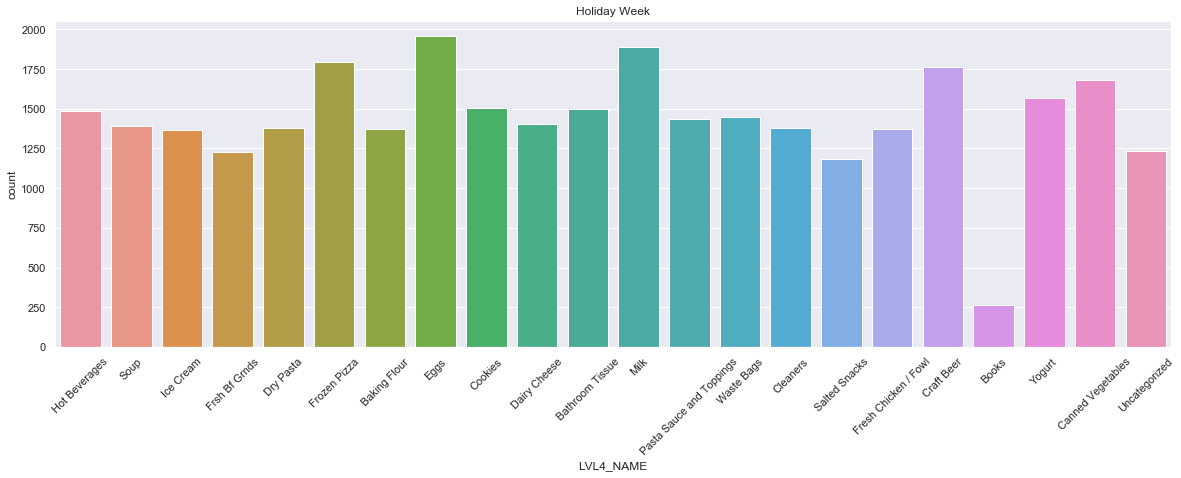

In [36]:
f, ax = plt.subplots(figsize=(20,6))
sns.countplot(x='LVL4_NAME', data=holidays, ax=ax)
plt.title("Holiday Week")
plt.xticks(rotation=45)

 *Let's see what are the five holidays associated with the most sale, e.g. Eggs*

In [37]:
Extract_most_sold(grp_hol, n=5).query("LVL4_NAME=='Eggs' ").head()

,LVL4_NAME,HOLIDAY,FREQ,TOTAL_UNITS
176,Eggs,Christmas / Boxing,157,882.598071
174,Eggs,Canada Day,133,694.736950
184,Eggs,Labor Day,132,704.649191
190,Eggs,Thanksgiving,131,680.636225
177,Eggs,Civic Holiday (Not for all),131,699.502755


*What is the most sold item?<br>
The most sold item  is 3332763 	Bathroom Tissue followed by items in the Milk category*

In [38]:
data1.groupby(by=['ITEM_NO','LVL4_NAME']).count().sort_values(by='GROUP_ID', ascending=False).head()

,,GROUP_ID,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,NET_PRICE,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK
ITEM_NO,LVL4_NAME,,,,,,,,,,,,
3332763,Bathroom Tissue,624,624,624,624,624,624,624,624,624,624,624,624
4039944,Milk,621,621,621,621,621,621,621,621,621,621,621,621
5923105,Milk,620,620,620,620,620,620,620,620,620,620,620,620
5103105,Milk,619,619,619,619,619,619,619,619,619,619,619,619
4286054,Canned Vegetables,618,618,618,618,618,618,618,618,618,618,618,618


*Extract the year in YEAR_WK*

In [39]:
data1['YEAR'] = data1['YEAR_WK'].apply(lambda x: int(str(x)[:4]))
data1.head(2)

,ITEM_NO,GROUP_ID,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,NET_PRICE,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME,YEAR
0,6156216,TR6156216,201936,TR,FRONT,1,9.916667,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019
1,6156216,TR6156216,202004,TR,FRONT,1,9.891305,Normal,-0.776529,0.013158,0.46,2.291656,4,Frsh Bf Grnds,2020


*What is the most sold category every week? Let's consider year 2019 for instance*

In [40]:
#weekly summary table
weekly_summary_table = data1.query("YEAR==2019").groupby(by=["WEEK","LVL4_NAME"]).agg(FREQ=("ITEM_NO","count"),TOTAL_UNITS=("LOG_UNITS","mean")).sort_values(by="WEEK").reset_index()
weekly_summary_table.head(3)

,WEEK,LVL4_NAME,FREQ,TOTAL_UNITS
0,1,Baking Flour,48,3.646527
1,1,Yogurt,57,4.611620
2,1,Waste Bags,49,3.836828


In [41]:
#extract the nth most sold item, here n is 5
def Extract_Weekly(weekly_summary_table, n=1):
    weekly_summ = pd.DataFrame(columns=weekly_summary_table.columns)
    for week in np.arange(1, 53):
        x = "WEEK=="  + str(week)
        weekly_summ = weekly_summ.append(weekly_summary_table.query(x).sort_values('FREQ', ascending=False).iloc[:n])
    return weekly_summ
weekly_summ = Extract_Weekly(weekly_summary_table, n=1)
weekly_summ.head()

,WEEK,LVL4_NAME,FREQ,TOTAL_UNITS
10,1,Frozen Pizza,62,4.086931
28,2,Milk,65,5.043235
44,3,Frozen Pizza,67,3.735714
81,4,Canned Vegetables,64,4.064910
98,5,Frozen Pizza,66,3.866568


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51]),
 <a list of 52 Text xticklabel objects>)

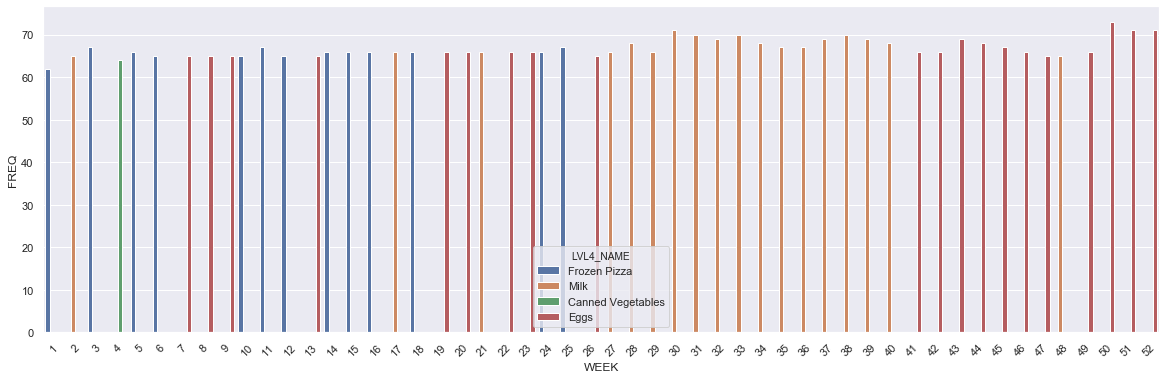

In [42]:
f, ax = plt.subplots(figsize=(20,6))
sns.barplot(x='WEEK', y='FREQ', data=weekly_summ , hue='LVL4_NAME', ax=ax)
plt.xticks(rotation=45)

*Count how many times each category was the most sold in 52 weeks<br>
In 2019, Egss represents 39% of most sold category per week, fallowed by Milk 35%*

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

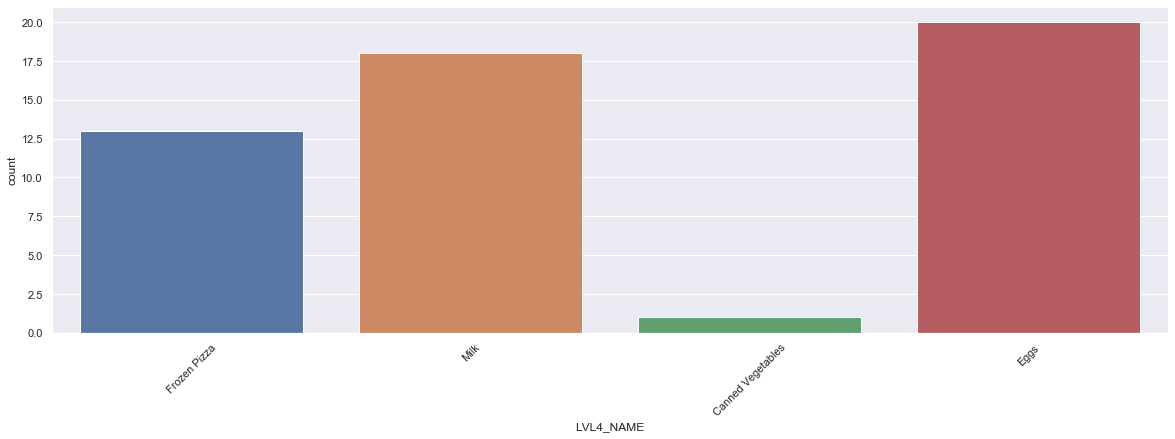

In [43]:
f, ax = plt.subplots(figsize=(20,6))
sns.countplot(x='LVL4_NAME', data=weekly_summ , ax=ax)
plt.xticks(rotation=45)

*Adding an extra column for visualization purpose*

In [44]:
unique_year_wk = np.sort( data1.YEAR_WK.unique() )
mappings = dict( zip(unique_year_wk, range(1, len(unique_year_wk)+1)) )
data1['N_YEAR_WK'] = data1.YEAR_WK.replace(mappings, inplace=False)
data1.head(3)         

,ITEM_NO,GROUP_ID,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,NET_PRICE,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME,YEAR,N_YEAR_WK
0,6156216,TR6156216,201936,TR,FRONT,1,9.916667,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43
1,6156216,TR6156216,202004,TR,FRONT,1,9.891305,Normal,-0.776529,0.013158,0.46,2.291656,4,Frsh Bf Grnds,2020,63
2,2669722,IG2669722,201847,IG,FRONT,0,3.934955,Normal,6.104793,0.674576,448.00,1.369900,47,Hot Beverages,2018,2


In [45]:
summ = data1.groupby(by=['N_YEAR_WK', 'LVL4_NAME']).agg(MEAN_LOG_UNITS=('LOG_UNITS', 'mean')).reset_index()
summ.head(2)

,N_YEAR_WK,LVL4_NAME,MEAN_LOG_UNITS
0,1,Baking Flour,3.097691
1,1,Bathroom Tissue,4.063827


*Visualizing category against mean units*

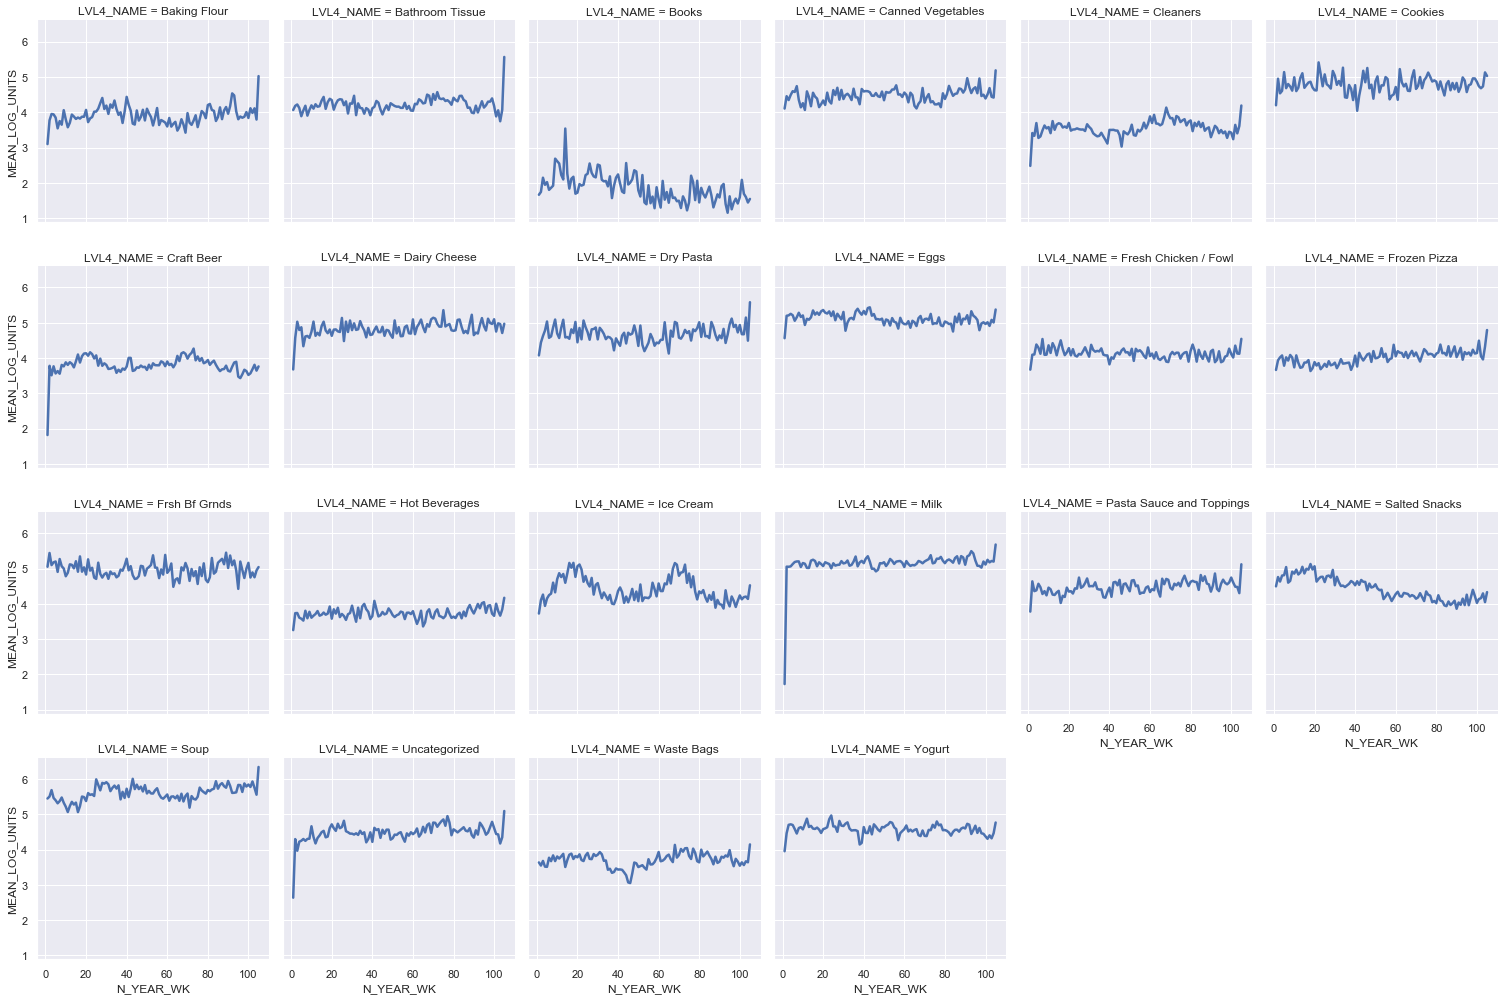

In [46]:
g = sns.FacetGrid(summ, col="LVL4_NAME", col_wrap=6, height=3.5)
g = g.map(plt.plot, "N_YEAR_WK", "MEAN_LOG_UNITS", linewidth=2.5)

*Some categories have a stationary like trend, seasonality trend, e.g. Ice Cream, and decreasing trend, e.g., Salted Snacks. Bathroom Tissue average unit jumps high at the end of the observation (202046) which maybe is due to the pandemic COVID19. Category Books has a peak value around weeks 15-19 which indicates the presence of an outlier since the next year we dont observe that. The Box plot below confirms that<br>
The ML algorithm which we will be using is not sensitive to outliers and might perform well on categories with stationary like trend but poorly for others*

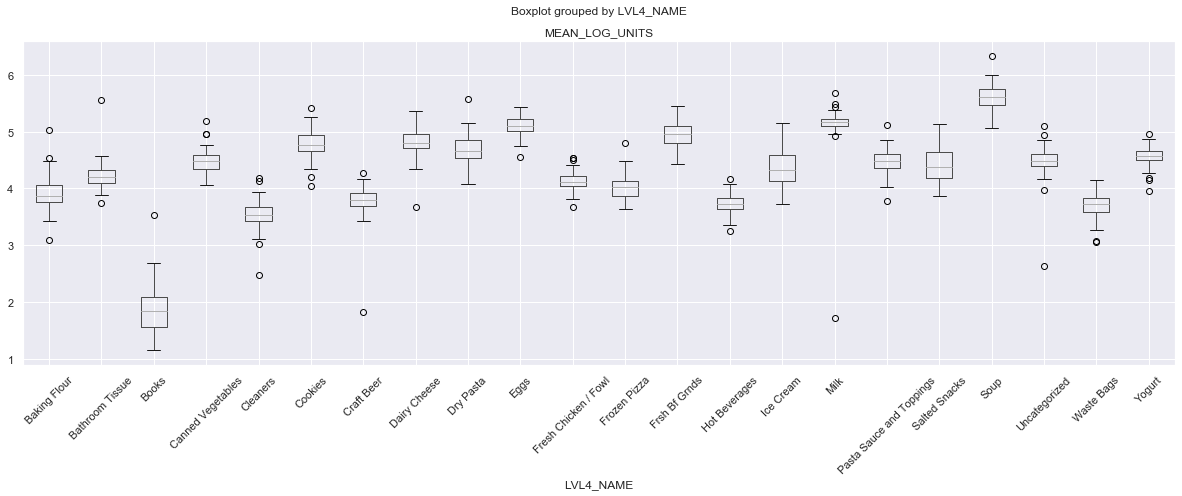

In [47]:
f, ax = plt.subplots(figsize=(20,6))
summ.boxplot(column=['MEAN_LOG_UNITS'], by='LVL4_NAME', ax=ax, rot=45)
#plt.xticks(rotation=45)

### More exploration (Cont.)

In [48]:
data2.loc[data2.CROSS_EFFECT_TYPE.str.contains('HALO', regex=False)==True, 'CROSS_EFFECT_TYPE2'] = 'Halo'
data2.loc[data2.CROSS_EFFECT_TYPE.str.contains('HALO', regex=False)==False, 'CROSS_EFFECT_TYPE2'] = 'Cannib'
data2.head()

,GROUP_ID,YEAR_WK,CROSS_EFFECT_TYPE,CROSS_EFFECT_LOG_PRICE,BANNER_NAME,ITEM_NO,LVL4_NAME,CROSS_EFFECT_TYPE2
0,TR4907644,201846.0,HALO_ITEM_LOG_PRICE_01,1.075020,TR,4907644.0,Canned Vegetables,Halo
1,TR4907644,201846.0,HALO_ITEM_LOG_PRICE_02,0.916291,TR,4907644.0,Canned Vegetables,Halo
2,TR4907644,201846.0,HALO_ITEM_LOG_PRICE_03,0.000000,TR,4907644.0,Canned Vegetables,Halo
3,TR4907644,201846.0,HALO_ITEM_LOG_PRICE_04,1.341123,TR,4907644.0,Canned Vegetables,Halo
4,TR4907644,201846.0,HALO_ITEM_LOG_PRICE_05,0.733477,TR,4907644.0,Canned Vegetables,Halo


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

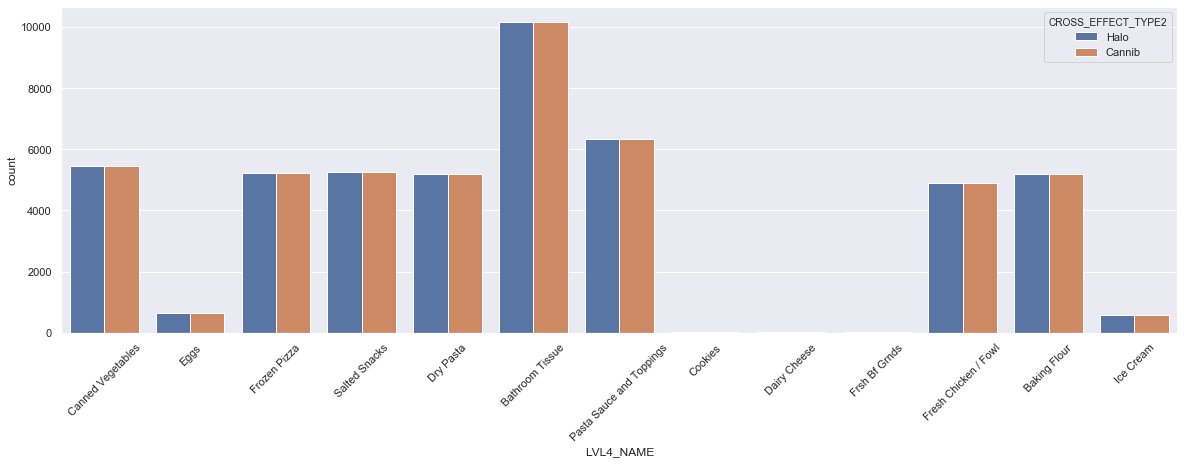

In [49]:
f, ax = plt.subplots(figsize=(20,6))
sns.countplot(x='LVL4_NAME', data=data2, hue='CROSS_EFFECT_TYPE2', ax=ax)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

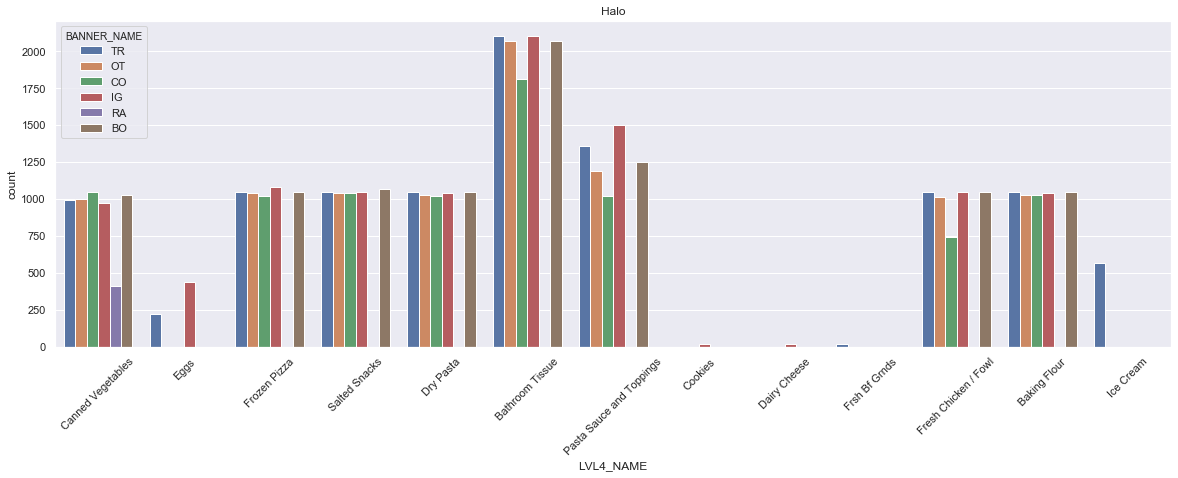

In [50]:
f, ax = plt.subplots(figsize=(20,6))
sns.countplot(x='LVL4_NAME', data=data2.query("CROSS_EFFECT_TYPE2=='Halo'"), hue='BANNER_NAME', ax=ax)
plt.title('Halo')
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

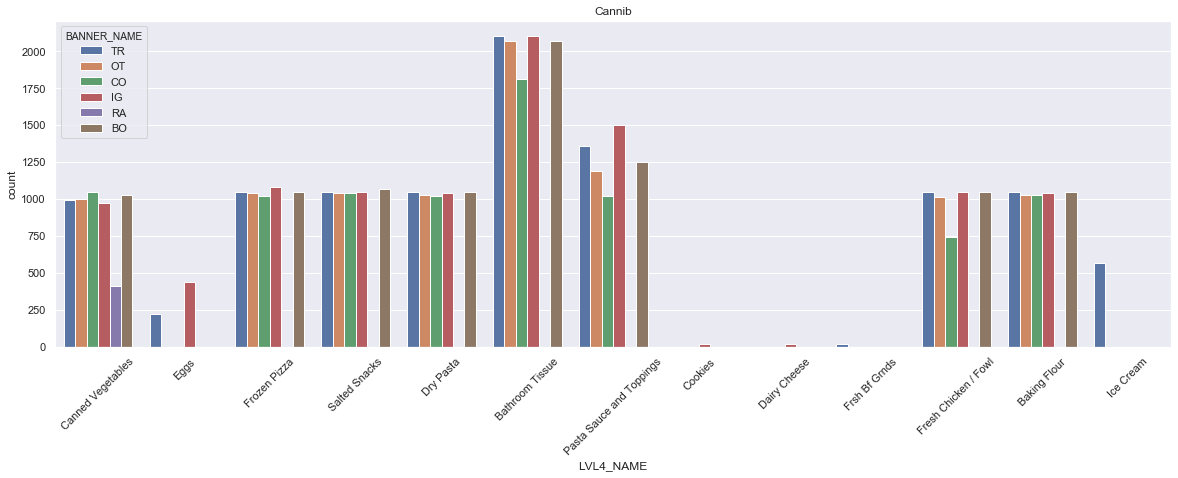

In [51]:
f, ax = plt.subplots(figsize=(20,6))
sns.countplot(x='LVL4_NAME', data=data2.query("CROSS_EFFECT_TYPE2=='Cannib'"), hue='BANNER_NAME', ax=ax)
plt.title('Cannib')
plt.xticks(rotation=45)

*The most sold item along with 10 other items not in the data sets is 4907644 (Canned Vegetables)*

In [52]:
data2.groupby(by=['CROSS_EFFECT_TYPE2','ITEM_NO', 'LVL4_NAME']).count().idxmax()

GROUP_ID                  (Cannib, 4907644.0, Canned Vegetables)
YEAR_WK                   (Cannib, 4907644.0, Canned Vegetables)
CROSS_EFFECT_TYPE         (Cannib, 4907644.0, Canned Vegetables)
CROSS_EFFECT_LOG_PRICE    (Cannib, 4907644.0, Canned Vegetables)
BANNER_NAME               (Cannib, 4907644.0, Canned Vegetables)
dtype: object

In [53]:
data2.describe()

,YEAR_WK,CROSS_EFFECT_LOG_PRICE,ITEM_NO
count,98380.000000,98380.000000,9.838000e+04
mean,201965.981500,0.581272,3.274926e+06
std,57.286626,0.781419,1.959800e+06
min,201846.000000,-1.213301,8.044680e+05
25%,201921.000000,0.000000,9.015690e+05
50%,201948.000000,0.000000,3.686053e+06
75%,202021.000000,1.231642,4.299104e+06
max,202046.000000,2.995232,9.100049e+06


*We see that the 50th percentile of CROSS_EFFECT_LOG_PRICE value is below 0.0 (or below 1 unit, e.g. 1 $).<br>
Some items do not have the cross effect type therefore when we join df1 and df2 we will have missing values for CROSS_EFFECT_LOG_PRICE. How we will resolve this?*

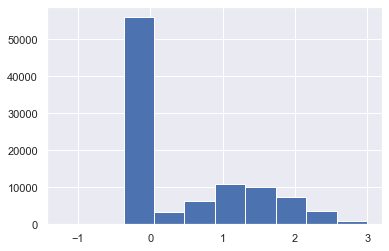

In [54]:
data2.CROSS_EFFECT_LOG_PRICE.hist()

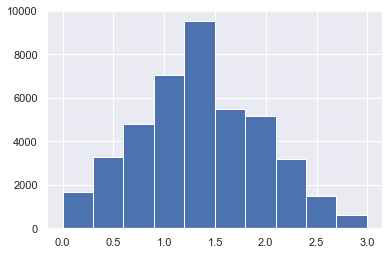

In [55]:
#by removing all prices less than 0 we get a nice distribution. Maybe this can help improve the model accurcay if necessary
data2.query("CROSS_EFFECT_LOG_PRICE>0.0")['CROSS_EFFECT_LOG_PRICE'].hist()

*We will use the mean of cross effect price if we dont get good performance in the modeling*

In [56]:
mean_price_data2 = data2.groupby(by=['GROUP_ID', 'YEAR_WK','CROSS_EFFECT_TYPE2', 'LVL4_NAME']).agg(MEAN_PRICE=('CROSS_EFFECT_LOG_PRICE','mean')).reset_index()
mean_price_data2.head()

,GROUP_ID,YEAR_WK,CROSS_EFFECT_TYPE2,LVL4_NAME,MEAN_PRICE
0,BO2835262,201846.0,Cannib,Fresh Chicken / Fowl,0.000000
1,BO2835262,201846.0,Halo,Fresh Chicken / Fowl,0.225563
2,BO2835262,201847.0,Cannib,Fresh Chicken / Fowl,0.000000
3,BO2835262,201847.0,Halo,Fresh Chicken / Fowl,0.293797
4,BO2835262,201848.0,Cannib,Fresh Chicken / Fowl,0.000000


# Modeling

In [57]:
data3 = pd.merge(data1, data2, how='left', on=['GROUP_ID','YEAR_WK','BANNER_NAME', 'ITEM_NO'])
data3.drop(['GROUP_ID','NET_PRICE', 'CROSS_EFFECT_TYPE', 'LVL4_NAME_y'], axis=1, inplace=True)
data3.head()

,ITEM_NO,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME_x,YEAR,N_YEAR_WK,CROSS_EFFECT_LOG_PRICE,CROSS_EFFECT_TYPE2
0,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,0.0,Halo
1,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,0.0,Halo
2,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,0.0,Halo
3,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,0.0,Halo
4,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,0.0,Halo


*data3 has some duplicated rows*

In [58]:
data4 = pd.merge(data1, mean_price_data2, how='left', on=['GROUP_ID','YEAR_WK'])
data4.drop(['GROUP_ID','NET_PRICE', 'LVL4_NAME_y'], axis=1, inplace=True)
data4.head()

,ITEM_NO,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME_x,YEAR,N_YEAR_WK,CROSS_EFFECT_TYPE2,MEAN_PRICE
0,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,Cannib,0.0
1,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,Halo,0.0
2,6156216,202004,TR,FRONT,1,Normal,-0.776529,0.013158,0.46,2.291656,4,Frsh Bf Grnds,2020,63,Cannib,0.0
3,6156216,202004,TR,FRONT,1,Normal,-0.776529,0.013158,0.46,2.291656,4,Frsh Bf Grnds,2020,63,Halo,0.0
4,2669722,201847,IG,FRONT,0,Normal,6.104793,0.674576,448.00,1.369900,47,Hot Beverages,2018,2,NaN,NaN


In [59]:
#let's remove duplicated rows
data3.drop_duplicates(keep='first', inplace=True)
data3.head()

,ITEM_NO,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME_x,YEAR,N_YEAR_WK,CROSS_EFFECT_LOG_PRICE,CROSS_EFFECT_TYPE2
0,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,0.0,Halo
10,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,0.0,Cannib
20,6156216,202004,TR,FRONT,1,Normal,-0.776529,0.013158,0.46,2.291656,4,Frsh Bf Grnds,2020,63,0.0,Halo
30,6156216,202004,TR,FRONT,1,Normal,-0.776529,0.013158,0.46,2.291656,4,Frsh Bf Grnds,2020,63,0.0,Cannib
40,2669722,201847,IG,FRONT,0,Normal,6.104793,0.674576,448.00,1.369900,47,Hot Beverages,2018,2,NaN,NaN


*Items or category that do not have cross effect, their missing values are replaced with 0 and are appended to cross effect type category NA.*

In [60]:
data3.CROSS_EFFECT_LOG_PRICE.fillna(0, axis=0, inplace=True)
data3.CROSS_EFFECT_TYPE2.fillna('NA', axis=0, inplace=True)
data3.head()

,ITEM_NO,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME_x,YEAR,N_YEAR_WK,CROSS_EFFECT_LOG_PRICE,CROSS_EFFECT_TYPE2
0,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,0.0,Halo
10,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,0.0,Cannib
20,6156216,202004,TR,FRONT,1,Normal,-0.776529,0.013158,0.46,2.291656,4,Frsh Bf Grnds,2020,63,0.0,Halo
30,6156216,202004,TR,FRONT,1,Normal,-0.776529,0.013158,0.46,2.291656,4,Frsh Bf Grnds,2020,63,0.0,Cannib
40,2669722,201847,IG,FRONT,0,Normal,6.104793,0.674576,448.00,1.369900,47,Hot Beverages,2018,2,0.0,NA


In [61]:
data4.MEAN_PRICE.fillna(0, axis=0, inplace=True)
data4.CROSS_EFFECT_TYPE2.fillna('NA', axis=0, inplace=True)
data4.head()

,ITEM_NO,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME_x,YEAR,N_YEAR_WK,CROSS_EFFECT_TYPE2,MEAN_PRICE
0,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,Cannib,0.0
1,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,Halo,0.0
2,6156216,202004,TR,FRONT,1,Normal,-0.776529,0.013158,0.46,2.291656,4,Frsh Bf Grnds,2020,63,Cannib,0.0
3,6156216,202004,TR,FRONT,1,Normal,-0.776529,0.013158,0.46,2.291656,4,Frsh Bf Grnds,2020,63,Halo,0.0
4,2669722,201847,IG,FRONT,0,Normal,6.104793,0.674576,448.00,1.369900,47,Hot Beverages,2018,2,NA,0.0


## Label Encoding

In [62]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

### Data prep for training

In [63]:
label_encoder = LabelEncoder()
#extract object categorical featrues
cols = data3.columns[data3.dtypes=="object"]
#transform them to numerics
#data3 = data3[cols].apply(label_encoder.fit_transform)
for col in cols:
    vec_cat = label_encoder.fit_transform(data3[col])
    data3[col] = vec_cat
data3.head()

,ITEM_NO,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME_x,YEAR,N_YEAR_WK,CROSS_EFFECT_LOG_PRICE,CROSS_EFFECT_TYPE2
0,6156216,201936,5,0,1,14,-2.120264,0.013158,0.12,2.294217,36,12,2019,43,0.0,1
10,6156216,201936,5,0,1,14,-2.120264,0.013158,0.12,2.294217,36,12,2019,43,0.0,0
20,6156216,202004,5,0,1,14,-0.776529,0.013158,0.46,2.291656,4,12,2020,63,0.0,1
30,6156216,202004,5,0,1,14,-0.776529,0.013158,0.46,2.291656,4,12,2020,63,0.0,0
40,2669722,201847,2,0,0,14,6.104793,0.674576,448.00,1.369900,47,13,2018,2,0.0,2


In [64]:
#drop date and units 
data3_train = data3.copy()
data3_train.drop(columns=['YEAR_WK', 'N_YEAR_WK', 'UNITS_WEIGHT_SOLD'], inplace=True)
data3_train.head()

,ITEM_NO,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,HOLIDAY,LOG_UNITS,DISTRIBUTION,LOG_NET_PRICE,WEEK,LVL4_NAME_x,YEAR,CROSS_EFFECT_LOG_PRICE,CROSS_EFFECT_TYPE2
0,6156216,5,0,1,14,-2.120264,0.013158,2.294217,36,12,2019,0.0,1
10,6156216,5,0,1,14,-2.120264,0.013158,2.294217,36,12,2019,0.0,0
20,6156216,5,0,1,14,-0.776529,0.013158,2.291656,4,12,2020,0.0,1
30,6156216,5,0,1,14,-0.776529,0.013158,2.291656,4,12,2020,0.0,0
40,2669722,2,0,0,14,6.104793,0.674576,1.369900,47,13,2018,0.0,2


In [65]:
target_col = 'LOG_UNITS'
feature_cols = data3_train.columns.drop(target_col)
X = data3_train[feature_cols]
y = data3_train[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Models

In [66]:
#A simple linear regresion model with default params
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
print('Test: R2_score:', reg.score(X_test, y_test))

Test: R2_score: 0.7159158658623368


In [67]:
reg_ypred = reg.predict(X_test)
reg_mse = metrics.mean_squared_error(y_test, reg_ypred)
print('rmse:', np.sqrt(reg_mse))

rmse: 1.1623044053135736


In [68]:
#Random forest
rdf = RandomForestRegressor(min_samples_leaf=5, n_estimators=10, random_state=0)
rdf.fit(X_train, y_train)
print('Test: R2_score:', rdf.score(X_test, y_test))

Test: R2_score: 0.9829253233761183


In [69]:
rdf_ypred = rdf.predict(X_test)
mse = metrics.mean_squared_error(y_test, rdf_ypred)
print('rmse:', np.sqrt(mse))

rmse: 0.2849526090874179


*Checking the model performance on the whole dataset*

In [70]:
reg_scores = cross_val_score(reg, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (reg_scores.mean(), reg_scores.std() * 2))

Accuracy: 0.69 (+/- 0.09)


In [71]:
rdf_scores = cross_val_score(rdf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (rdf_scores.mean(), rdf_scores.std() * 2))

Accuracy: 0.86 (+/- 0.03)


*Feature importances*

In [72]:
label_encod_feature_scores = pd.Series(rdf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

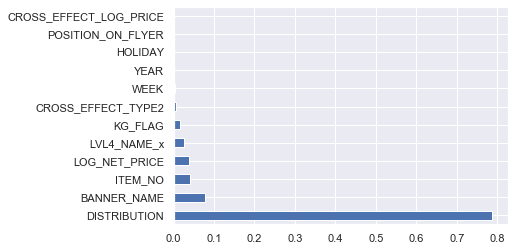

In [73]:
label_encod_feature_scores.plot.barh()

*Surprisingly, HOLIDAY is not an important feature. The reason might be due to the fact that the data is weekly aggregated which kinda cancel out the effect of holiday which is a matter 1 or 2 days. Maybe it the data was not aggregate (giving daily) then HOLIDAY might influance the model. As we suspected, DISTRIBUTION is the main driver in the prediction. BANNER_NAME, ITEM_NO, LVL4_NAME have been influenced by the most use banner IG, most sold item, most sold category (Eggs, Milk) respectively*

In [74]:
test_df = pd.concat([X_test, y_test], axis=1)
test_df['PRED_LOG_UNITS'] = rdf_ypred
test_df['ERROR_2'] = (y_test - rdf_ypred)**2
test_df.head()

,ITEM_NO,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,HOLIDAY,DISTRIBUTION,LOG_NET_PRICE,WEEK,LVL4_NAME_x,YEAR,CROSS_EFFECT_LOG_PRICE,CROSS_EFFECT_TYPE2,LOG_UNITS,PRED_LOG_UNITS,ERROR_2
192170,801568,1,0,0,6,0.019231,0.688135,42,19,2020,0.000000,2,2.772589,2.718410,0.002935
69379,901569,2,0,0,6,0.989831,1.606895,42,0,2020,1.097184,1,8.112827,8.130109,0.000299
31987,804468,5,1,0,14,0.907895,-0.287953,46,16,2020,0.904999,0,7.075809,6.990630,0.007255
165311,5081525,5,0,0,6,0.210526,1.597947,42,13,2019,0.000000,2,4.465908,4.356321,0.012009
133177,8442368,0,0,0,14,0.202899,1.383791,45,9,2019,0.000000,2,4.779123,4.852885,0.005441


*Computing RMSE at the category level*

In [75]:
rmse_by_cat =  test_df.groupby(by='LVL4_NAME_x').agg(RMSE_1=('ERROR_2',lambda x:np.sqrt(np.mean(x)))).reset_index()
rmse_by_cat['Category'] = np.sort(data1['LVL4_NAME'].unique())
#rmse_by_cat.drop(column='LVL4_NAME')
rmse_by_cat

,LVL4_NAME_x,RMSE_1,Category
0,0,0.244042,Baking Flour
1,1,0.207740,Bathroom Tissue
2,2,0.385541,Books
3,3,0.246830,Canned Vegetables
4,4,0.242837,Cleaners
5,5,0.270960,Cookies
6,6,0.287825,Craft Beer
7,7,0.343143,Dairy Cheese
8,8,0.274402,Dry Pasta
9,9,0.505696,Eggs


## Using OneHot representation 

## Data prep for training

In [76]:
data3b = pd.merge(data1, data2, how='left', on=['GROUP_ID','YEAR_WK','BANNER_NAME', 'ITEM_NO'])
data3b.drop(['GROUP_ID','NET_PRICE', 'CROSS_EFFECT_TYPE', 'LVL4_NAME_y'], axis=1, inplace=True)
data3b.head(2)

,ITEM_NO,YEAR_WK,BANNER_NAME,POSITION_ON_FLYER,KG_FLAG,HOLIDAY,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,LVL4_NAME_x,YEAR,N_YEAR_WK,CROSS_EFFECT_LOG_PRICE,CROSS_EFFECT_TYPE2
0,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,0.0,Halo
1,6156216,201936,TR,FRONT,1,Normal,-2.120264,0.013158,0.12,2.294217,36,Frsh Bf Grnds,2019,43,0.0,Halo


In [77]:
data3b.CROSS_EFFECT_LOG_PRICE.fillna(0, axis=0, inplace=True)

In [78]:
obj_cols = data3b.columns[data3b.dtypes=='object']
obj_cols

Index(['BANNER_NAME', 'POSITION_ON_FLYER', 'HOLIDAY', 'LVL4_NAME_x',
       'CROSS_EFFECT_TYPE2'],
      dtype='object')

In [79]:
data3b = pd.get_dummies(data3b)
data3b.head()

,ITEM_NO,YEAR_WK,KG_FLAG,LOG_UNITS,DISTRIBUTION,UNITS_WEIGHT_SOLD,LOG_NET_PRICE,WEEK,YEAR,N_YEAR_WK,...,LVL4_NAME_x_Ice Cream,LVL4_NAME_x_Milk,LVL4_NAME_x_Pasta Sauce and Toppings,LVL4_NAME_x_Salted Snacks,LVL4_NAME_x_Soup,LVL4_NAME_x_Uncategorized,LVL4_NAME_x_Waste Bags,LVL4_NAME_x_Yogurt,CROSS_EFFECT_TYPE2_Cannib,CROSS_EFFECT_TYPE2_Halo
0,6156216,201936,1,-2.120264,0.013158,0.12,2.294217,36,2019,43,...,0,0,0,0,0,0,0,0,0,1
1,6156216,201936,1,-2.120264,0.013158,0.12,2.294217,36,2019,43,...,0,0,0,0,0,0,0,0,0,1
2,6156216,201936,1,-2.120264,0.013158,0.12,2.294217,36,2019,43,...,0,0,0,0,0,0,0,0,0,1
3,6156216,201936,1,-2.120264,0.013158,0.12,2.294217,36,2019,43,...,0,0,0,0,0,0,0,0,0,1
4,6156216,201936,1,-2.120264,0.013158,0.12,2.294217,36,2019,43,...,0,0,0,0,0,0,0,0,0,1


In [80]:
data3b_train = data3b.copy()
drop_cols = ['YEAR_WK','UNITS_WEIGHT_SOLD', 'N_YEAR_WK']
data3b_train.drop(columns=drop_cols, inplace=True)
feature_cols = data3b_train.columns.drop(target_col)

X = data3b_train[feature_cols]
y = data3b_train[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Models

*A simple linear regression model with default parms*

In [81]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
print('Test: R2_score:', reg.score(X_test, y_test))

Test: R2_score: 0.832583785937101


In [82]:
reg_ypred = reg.predict(X_test)
reg_mse = metrics.mean_squared_error(y_test, reg_ypred)
print('rmse:', np.sqrt(reg_mse))

rmse: 0.894595560585494


*Random Forest*

In [83]:
rdf = RandomForestRegressor(min_samples_leaf=5, n_estimators=10, random_state=0)
rdf.fit(X_train, y_train)
print('Test: R2_score:', rdf.score(X_test, y_test))

Test: R2_score: 0.9870528044131095


In [84]:
rdf_ypred = rdf.predict(X_test)
mse = metrics.mean_squared_error(y_test, rdf_ypred)
print('rmse:', np.sqrt(mse))

rmse: 0.24878021266031655


*Checking model performance on the whole dataset*

In [85]:
scores = cross_val_score(reg, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.79 (+/- 0.03)


In [86]:
rdf_scores = cross_val_score(rdf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (rdf_scores.mean(), rdf_scores.std() * 2))

Accuracy: 0.89 (+/- 0.03)


*Feature importances*

In [87]:
feature_scores = pd.Series(rdf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

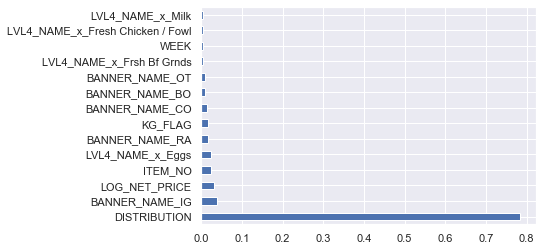

In [88]:
feature_scores[:14].plot.barh()

In [89]:
test_df2 = pd.concat([X_test, y_test], axis=1)
test_df2['PRED_LOG_UNITS'] = rdf_ypred
test_df2['ERROR_2'] = (y_test-rdf_ypred)**2
test_df2.head()

,ITEM_NO,KG_FLAG,DISTRIBUTION,LOG_NET_PRICE,WEEK,YEAR,CROSS_EFFECT_LOG_PRICE,BANNER_NAME_BO,BANNER_NAME_CO,BANNER_NAME_IG,...,LVL4_NAME_x_Salted Snacks,LVL4_NAME_x_Soup,LVL4_NAME_x_Uncategorized,LVL4_NAME_x_Waste Bags,LVL4_NAME_x_Yogurt,CROSS_EFFECT_TYPE2_Cannib,CROSS_EFFECT_TYPE2_Halo,LOG_UNITS,PRED_LOG_UNITS,ERROR_2
5646,5483765,1,0.105263,2.580165,52,2019,0.00000,0,0,0,...,0,0,0,0,0,0,0,5.238716,5.267875,0.000850
186306,1060871,0,0.362319,1.988921,27,2020,0.00000,1,0,0,...,0,0,0,0,0,0,0,3.931826,3.982732,0.002591
163126,3175703,0,0.115044,1.703687,32,2019,0.00000,0,0,0,...,0,0,0,0,0,0,0,3.178054,3.680038,0.251988
185167,1144231,0,0.881579,1.522366,30,2019,0.00000,0,0,0,...,0,0,0,0,0,0,0,5.662960,5.783029,0.014416
17868,7780727,0,0.008850,1.665818,20,2020,1.61077,0,0,0,...,0,0,0,0,0,1,0,0.000000,0.000000,0.000000


In [93]:
#checking rmse for Eggs
category = test_df2.columns[test_df2.columns.str.contains('LVL4_NAME', regex=True)]
names = ["".join(elt) for elt in [cat.split(" ") for cat in category] ]
new_name = dict(zip(category, names))

new_name['LVL4_NAME_x_FreshChicken/Fowl'] = 'LVL4_NAME_x_FreshChicken_Fowl'
test_df2.rename(columns=new_name, inplace=True)
category = test_df2.columns[test_df2.columns.str.contains('LVL4_NAME', regex=True)]
lst = []
for cat in category:
    char_str = cat + '==1'
    lst.append([cat[12:],np.sqrt(test_df2.query(char_str)['ERROR_2'].mean())])
err = pd.DataFrame(lst, columns=['Category2','RSME_2'])
compar = pd.concat([rmse_by_cat, err], axis=1)
compar.drop(columns=['LVL4_NAME_x', 'Category2'])

,RMSE_1,Category,RSME_2
0,0.244042,Baking Flour,0.187346
1,0.207740,Bathroom Tissue,0.151342
2,0.385541,Books,0.377949
3,0.246830,Canned Vegetables,0.199423
4,0.242837,Cleaners,0.228403
5,0.270960,Cookies,0.265144
6,0.287825,Craft Beer,0.268828
7,0.343143,Dairy Cheese,0.362733
8,0.274402,Dry Pasta,0.262076
9,0.505696,Eggs,0.446910


*Using OneHot encoding greatly imporved linear regression score from 0.71 to 0.81 but not a significant improvement for the RandomForest.<br>
However, the REMSE at the categorical level seems to be improved for some categories, e.g., Eggs RMSE improved from the label encoding to OneHot (0.5 to 0.44) which we already suspected this behavior*